### Branch and Bound  

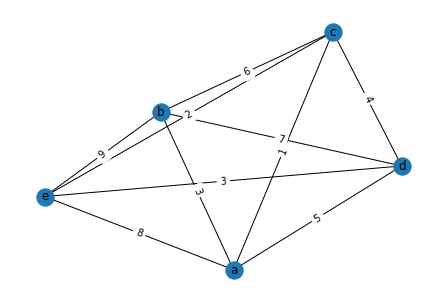

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math

def drawGraph(G):
    layout = nx.spring_layout(G)
    nx.draw(G, layout)
    nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=nx.get_edge_attributes(G, 'weight'))
    labels = {i: chr(ord('a') + i) for i in range(len(A))}
    nx.draw_networkx_labels(G, pos=layout, labels=labels)
    plt.show()

A = [[0, 3, 1, 5, 8],
    [3, 0, 6, 7, 9],
    [1, 6, 0, 4, 2],
    [5, 7, 4, 0, 3],
    [8, 9, 2, 3, 0]]

A = nx.from_numpy_matrix(np.matrix(A), create_using=nx.Graph)
drawGraph(A)

## generate a weighted graph
G2 = nx.complete_graph(100)
for (u, v) in G2.edges():
    G2[u][v]['weight'] = np.random.randint(1, 10)

In [21]:
class Node:
    def __init__(self, bound, boundEdges, level, cost, solution):
        self.bound = bound
        self.boundEdges = boundEdges
        self.level = level
        self.cost = cost
        self.solution = solution
    
    def __lt__(self, other):
        return self.bound < other.bound
    
    def __repr__(self) -> str:
        return f"Node({self.bound}, {self.boundEdges}, {self.level}, {self.cost}, {self.solution})"


def findTwoMinimalEdges(list):
    min1 = np.inf
    min2 = np.inf
    for j in list:
        if list[j]['weight'] < min1:
            min2 = min1
            min1 = list[j]['weight']
        elif list[j]['weight'] < min2:
            min2 = list[j]['weight']
    return min1, min2

def findInitialBound(A):
    bound = 0
    initialBoundEdges = np.zeros((A.number_of_nodes(), 2), dtype=list)
    for i in range(A.number_of_nodes()):
        min1, min2 = findTwoMinimalEdges(A[i])
        initialBoundEdges[i][0] = min1
        initialBoundEdges[i][1] = min2
        bound += min1 + min2
    return math.ceil(bound / 2), initialBoundEdges

def findBound(A, solution, boundEdges):
    changedEdges = np.zeros(A.number_of_nodes(), dtype=int)
    newEdges = np.array(boundEdges)
    edgeWeight = A[solution[-2]][solution[-1]]['weight']
    if newEdges[solution[-2]][0] != edgeWeight:
        if changedEdges[solution[-2]] == 0:
            newEdges[solution[-2]][1] = edgeWeight
        else:
            newEdges[solution[-2]][0] = edgeWeight
        changedEdges[solution[-2]] += 1
    if newEdges[solution[-1]][0] != edgeWeight:
        if changedEdges[solution[-1]] == 0:
            newEdges[solution[-1]][1] = edgeWeight
        else:
            newEdges[solution[-1]][0] = edgeWeight
        changedEdges[solution[-1]] += 1
    sum = np.sum(newEdges)
    return math.ceil(sum / 2), newEdges


In [22]:
from heapq import heappush, heappop

def branchAndBoundTSP(A):
    initialBound, initialBoundEdges = findInitialBound(A)
    root = Node(initialBound, initialBoundEdges, 1, 0, [0])
    heap = []
    heappush(heap, root)
    best = np.inf
    solution = []
    while heap:
        node = heappop(heap)
        
        if node.level > A.number_of_nodes():
            if best > node.cost:
                best = node.cost
                solution = node.solution
        else:
            if node.bound < best:
                if node.level < A.number_of_nodes():
                    for k in range(1, A.number_of_nodes()):
                        try:
                            edgeWeight = A[node.solution[-1]][k]['weight']
                        except KeyError:
                            continue
                        newBound, newEdges = findBound(A, node.solution + [k], node.boundEdges) 
                        if k not in node.solution and newBound < best:
                            newNode = Node(newBound, newEdges, node.level + 1, node.cost + edgeWeight, node.solution + [k])
                            if k == 2:
                                if 1 not in node.solution:
                                    continue 
                            heappush(heap, newNode)
                else:
                    newBound, newEdges = findBound(A, node.solution + [0], node.boundEdges)
                    edgeWeight = A[node.solution[-1]][0]['weight']
                    if edgeWeight != 0 and newBound < best:
                        newNode = Node(newBound, newEdges, node.level + 1, node.cost + edgeWeight, node.solution + [0])
                        heappush(heap, newNode)
    return best, solution

In [23]:
branchAndBoundTSP(A)

(22, [0, 9, 3, 15, 10, 11, 1, 5, 12, 4, 7, 6, 13, 2, 8, 14, 0])

### Twice Around The Tree

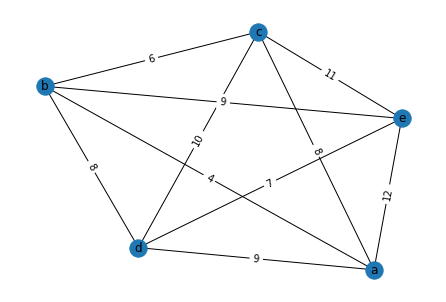

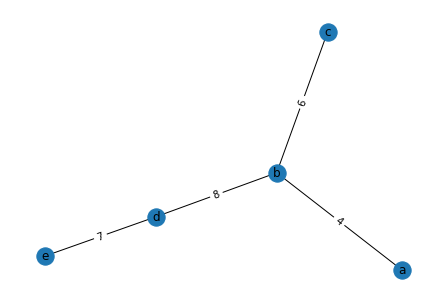

[0, 1, 2, 3, 4, 0]


39

In [24]:
G2 = [[0, 4, 8, 9, 12],
    [4, 0, 6, 8, 9],
    [8, 6, 0, 10, 11],
    [9, 8, 10, 0, 7],   
    [12, 9, 11, 7, 0]]
G2 = nx.from_numpy_matrix(np.matrix(G2), create_using=nx.Graph)
drawGraph(G2)
MST = nx.minimum_spanning_tree(G2)
drawGraph(MST)
def preOrderTraversal(G, root, visited, path):
    visited[root] = True
    path.append(root)
    for i in G[root]:
        if visited[i] == False:
            preOrderTraversal(G, i, visited, path)
    return path

def findWeight(G, path):
    weight = 0
    for i in range(len(path) - 1):
        weight += G[path[i]][path[i + 1]]['weight']
    return weight

print(preOrderTraversal(MST, 0, np.zeros(G2.number_of_nodes(), dtype=bool), []) + [0])
findWeight(G2, preOrderTraversal(MST, 0, np.zeros(G2.number_of_nodes(), dtype=bool), []) + [0])


In [25]:
MST.edges

EdgeView([(0, 1), (1, 2), (1, 3), (3, 4)])

In [26]:
print(A[0])
print(A[0][1])
print(A[0][1]['weight'])

{1: {'weight': 3}, 2: {'weight': 1}, 3: {'weight': 5}, 4: {'weight': 8}}
{'weight': 3}
3
